# Metadata

```
Course:   DS 5001
Module:   04 Lab
Topic:    Predict POS with an HMM
Author:   R.C. Alvarado
```

# Set Up

In [1]:
data_in = './data_in'
data_out = './data_out'
data_prefix = 'austen-melville'

In [4]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
SENT = OHCO[:4]

In [5]:
import pandas as pd
import numpy as np
import nltk
import re

# Get Annotated `TOKEN` Table

In [6]:
TOKEN = pd.read_csv(f"{data_out}/{data_prefix}-TOKEN.csv").set_index(OHCO)

In [7]:
TOKEN[['pos','term_str']].head(20)

pos     term_str
book_id chap_num para_num sent_num token_num                  
158     1        1        0        0          NNP         emma
                                   1          NNP    woodhouse
                                   2           NN     handsome
                                   3           NN       clever
                                   4           CC          and
                                   5           NN         rich
                                   6           IN         with
                                   7           DT            a
                                   8           JJ  comfortable
                                   9           NN         home
                                   10          CC          and
                                   11          JJ        happy
                                   12          NN  disposition
                                   13         VBD       seemed
                                   14          TO           to
                                   15          VB        unite
                                   16          DT         some
                                   17          IN           of
                                   18          DT          the
                                   19         JJS         best

## Create Table of Tags 

From the Penn Treebank Project

### Grab UPenn Codes

We get a text version of the UPenn Codes, or tag set, by calling `nltk.help.upenn_tagset()`. There is a script in `data_in` that will generate this file for you, although a copy of it has already been generated. We use this to add a definition column to our table. This can be used later in visualizations, etc.

In [6]:
POS = pd.read_csv(f'{data_in}/upenn_tagset.txt', sep='\t', names=['pos_code','def'])
POS = POS[POS.pos_code.str.match(r'^\w')].set_index('pos_code') # Keep only letter codes

In [7]:
# POS

### Add value counts

In [8]:
POS['n'] = TOKEN.pos.value_counts().to_frame('n').sort_index()
POS['n'] = POS['n'].fillna(0).astype('int')

In [9]:
# POS

In [10]:
# POS.sort_values('n', ascending=False)

### Create `POS_GROUP` table

We want a simplified list of grammatical categories. We use the first two letters of each code name as our group.

In [11]:
# Add pos_group feature to POS and TOKEN
POS['pos_group'] = POS.apply(lambda x: x.name[:2], 1)
TOKEN['pos_group'] = TOKEN.pos.str[:2]

In [12]:
# Generate new table from it
POS_GROUP = POS.groupby('pos_group').n.sum().to_frame('n')
POS_GROUP = POS_GROUP[POS_GROUP.n > 0]
POS_GROUP['def'] = POS.groupby('pos_group').apply(lambda x: '; '.join(x['def']))
POS_GROUP['p'] = POS_GROUP.n / POS_GROUP.n.sum()
POS_GROUP['i'] = np.log2(1/POS_GROUP.p)
POS_GROUP['h'] = POS_GROUP.p * POS_GROUP.i

In [13]:
POS_GROUP.sort_values('i')

,n,def,p,i,h
pos_group,,,,,
NN,543729,"noun, common, singular or mass; noun, proper...",0.262582,1.929159,0.506563
VB,357450,"verb, base form; verb, past tense; verb, pr...",0.172623,2.534305,0.437479
IN,265490,"preposition or conjunction, subordinating",0.128213,2.963389,0.379944
DT,206083,determiner,0.099523,3.328821,0.331295
PR,177425,"pronoun, personal; pronoun, possessive",0.085684,3.544837,0.303734
JJ,166430,"adjective or numeral, ordinal; adjective, co...",0.080374,3.637131,0.292330
RB,119147,"adverb; adverb, comparative; adverb, superl...",0.057539,4.119304,0.237023
CC,84141,"conjunction, coordinating",0.040634,4.621166,0.187777
TO,55539,"""to"" as preposition or infinitive marker",0.026821,5.220474,0.140020


## Remove punctation from `TOKEN`

In [14]:
TOKEN = TOKEN.join(POS, on="pos_group", rsuffix='_y').dropna()

In [15]:
TOKEN

pos_tuple  pos  \
book_id chap_num para_num sent_num token_num                               
158     1        1        0        0                ('Emma', 'NNP')  NNP   
                                   1          ('Woodhouse,', 'NNP')  NNP   
                                   2            ('handsome,', 'NN')   NN   
                                   3              ('clever,', 'NN')   NN   
                                   4                  ('and', 'CC')   CC   
...                                                             ...  ...   
10712   92       23       0        6                  ('is', 'VBZ')  VBZ   
                                   7                    ('a', 'DT')   DT   
                                   8               ('voyage', 'NN')   NN   
                                   9               ("that's", 'NN')   NN   
                                   12              ('bound!', 'NN')   NN   

                                               token_str   term_str pos_group  \
book_id chap_num para_num sent_num token_num                                    
158     1        1        0        0                Emma       emma        NN   
                                   1          Woodhouse,  woodhouse        NN   
                                   2           handsome,   handsome        NN   
                                   3             clever,     clever        NN   
                                   4                 and        and        CC   
...                                                  ...        ...       ...   
10712   92       23       0        6                  is         is        VB   
                                   7                   a          a        DT   
                                   8              voyage     voyage        NN   
                                   9              that's      thats        NN   
                                   12             bound!      bound        NN   

                                                                          def  \
book_id chap_num para_num sent_num token_num                                    
158     1        1        0        0           noun, common, singular or mass   
                                   1           noun, common, singular or mass   
                                   2           noun, common, singular or mass   
                                   3           noun, common, singular or mass   
                                   4                conjunction, coordinating   
...                                                                       ...   
10712   92       23       0        6                          verb, base form   
                                   7                               determiner   
                                   8           noun, common, singular or mass   
                                   9           noun, common, singular or mass   
                                   12          noun, common, singular or mass   

                                                     n pos_group_y  
book_id chap_num para_num sent_num token_num                        
158     1        1        0        0          389683.0          NN  
                                   1          389683.0          NN  
                                   2          389683.0          NN  
                                   3          389683.0          NN  
                                   4           84141.0          CC  
...                                                ...         ...  
10712   92       23       0        6           90525.0          VB  
                                   7          206083.0          DT  
                                   8          389683.0          NN  
                                   9          389683.0          NN  
                                   12         389683.0          NN  

[1865239 rows x 8 columns]

## Create Table of $t_n \rightarrow t_{n+1}$ Transisions ($A$)

**Add sentence boundaries to sequence**

Note that we are breaking our data by adding `<s>` as a key, although 
it is not part of the UPenn tagset. We might consider creating a code 
for sentence beginnings or endings, such as the stop tag in Eistenstein 2019.

In [16]:
# TOKEN

In [17]:
T1 = TOKEN.pos_group.to_frame().reset_index().copy()
T2 = T1.copy()
T1.token_num += 1
A = T1.merge(T2, on=OHCO, how='outer').fillna('<s>')\
    [['pos_group_x', 'pos_group_y']].value_counts().to_frame('n')
A['cp'] = A.n / A.groupby('pos_group_x').n.sum()
A['rcp'] = A.n / A.groupby('pos_group_y').n.sum()

In [18]:
A

n        cp       rcp
pos_group_x pos_group_y                            
DT          NN           133802  0.649263  0.246284
NN          <s>          132713  0.244280  0.442882
            IN           127939  0.235492  0.481899
JJ          NN            98452  0.591705  0.181217
IN          DT            93077  0.350587  0.451648
...                         ...       ...       ...
CC          UH                1  0.000012  0.010000
UH          MD                1  0.010000  0.000031
            DT                1  0.010000  0.000005
CD          FW                1  0.000079  0.001996
FW          RP                1  0.001996  0.000127

[232 rows x 3 columns]

In [19]:
AM = A.cp.unstack(fill_value=0)

In [20]:
AM.T.style.background_gradient()

pos_group_x,,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,RB,RP,TO,UH,VB,WP
pos_group_y,,,,,,,,,,,,,,,,,
,0.000000,0.133455,0.048304,0.010908,0.063117,0.309381,0.206268,0.102772,0.600000,0.049236,0.244280,0.051475,0.178065,0.102739,0.130000,0.177987,0.198463
CC,0.035891,0.000582,0.052178,0.000883,0.001818,0.041916,0.002049,0.045971,0.000000,0.003915,0.099239,0.021856,0.025583,0.001909,0.000000,0.020369,0.003055
CD,0.005303,0.013170,0.015258,0.009700,0.001299,0.021956,0.011658,0.004285,0.000000,0.000814,0.001704,0.005061,0.007219,0.004213,0.000000,0.005760,0.002870
DT,0.073057,0.108364,0.007036,0.001907,0.024416,0.151697,0.350587,0.018439,0.000000,0.011620,0.022022,0.044777,0.221125,0.153964,0.010000,0.138949,0.059428
EX,0.003908,0.005242,0.000316,0.000097,0.000000,0.000000,0.002260,0.000313,0.000000,0.000063,0.001657,0.001653,0.000000,0.000072,0.000000,0.001256,0.000926
FW,0.000254,0.000012,0.000079,0.000325,0.000000,0.047904,0.000328,0.000385,0.000000,0.000000,0.000289,0.000025,0.000127,0.000000,0.000000,0.000050,0.000185
IN,0.077976,0.102944,0.164124,0.013097,0.020779,0.019960,0.031790,0.085620,0.200000,0.012591,0.235492,0.133484,0.328901,0.002683,0.040000,0.163853,0.032028
JJ,0.069389,0.080563,0.096371,0.248356,0.009091,0.031936,0.074139,0.062517,0.000000,0.000877,0.011902,0.195753,0.026089,0.008138,0.050000,0.070849,0.043877
LS,0.000017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<AxesSubplot:xlabel='pos_group_y'>

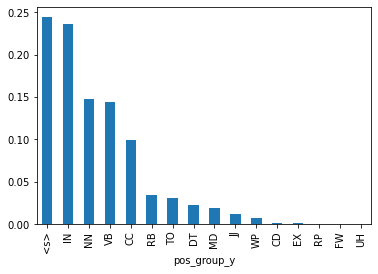

In [21]:
A.loc['NN'].cp.plot.bar() # P(Ay|Ax)

<AxesSubplot:xlabel='pos_group_y'>

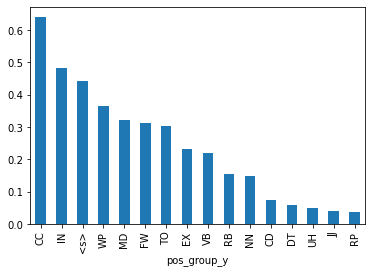

In [22]:
A.loc['NN'].rcp.sort_values(ascending=False).plot.bar() # p(Ax|Ay)

## Create Table of Initial State Probabilities ($\pi$ or `PI`)

In [23]:
PI = A.loc['<s>'] #.n.to_frame()
PI.index.name = 'pos_group'

In [24]:
# PI

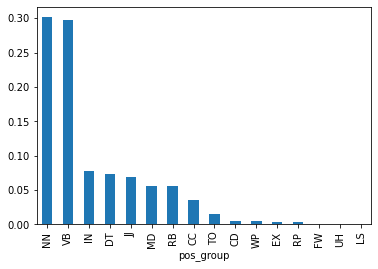

In [25]:
PI.sort_values('cp', ascending=False).cp.plot.bar();

## Create Table of $t_n \rightarrow o_n$ Emissions ($ B $)

In [26]:
B = TOKEN[['pos_group', 'term_str']].value_counts().to_frame('n')
B['cp'] = B.n / B.groupby('pos_group').n.sum()
B['rcp'] = B.n / B.groupby('term_str').n.sum()

In [27]:
BM = B.cp.unstack(fill_value=0)

In [28]:
B.loc['JJ'].sort_values('n', ascending=False).head(10)

,n,cp,rcp
term_str,,,
such,3142,0.018884,0.964988
little,3013,0.018108,0.915805
old,2864,0.017213,0.911521
good,2611,0.015692,0.882393
other,2498,0.015013,0.781358
own,2405,0.014454,0.846533
more,2313,0.013901,0.432256
great,2264,0.013607,0.948471
much,2238,0.013451,0.636157


In [29]:
B.loc['NN'].sort_values('n', ascending=False).head(10)

,n,cp,rcp
term_str,,,
it,4257,0.007836,0.781244
man,3826,0.007042,0.976269
mr,3366,0.006196,0.984786
time,3335,0.006139,0.968351
him,2882,0.005305,0.794815
mrs,2662,0.004900,0.999249
i,2489,0.004581,0.827185
me,2255,0.004151,0.689813
day,2045,0.003764,0.971035


In [30]:
B.loc['VB'].sort_values('n', ascending=False).head(10)

,n,cp,rcp
term_str,,,
was,23770,0.066499,0.985203
be,15342,0.042921,0.991534
had,13425,0.037558,0.985032
is,13288,0.037175,0.964016
have,10362,0.028989,0.995198
were,8050,0.022521,0.990404
been,5939,0.016615,0.983115
are,5597,0.015658,0.967502
said,4340,0.012142,0.920662


## Create a State Graph of $A$

We do this for the fun of it. It shows how complicated these state machines can get!

In [31]:
λ = .001
edges = A[A.cp > λ].apply(lambda x: f'"{x.name[0]}" -> "{x.name[1]}" [label="{round(x.cp,4)}"]', 1).to_list()

In [32]:
E = '\n'.join(edges)
G = "digraph G {\n"
G += "\trankdir=LR"
for edge in edges:
    G += f"\t{edge}\n"
G += "}\n"

In [33]:
with open(f'{data_out}/state-graph-{λ}.dot', 'w') as outfile:
    outfile.write(G)

In [34]:
!dot {data_out}/state-graph-{λ}.dot -Tpng -O

<img src="data_out/state-graph-0.001.dot.png">

## Implement Viterbi


<img src="data_out/viterbi.png" width="750">

In [35]:
def viterbi(sent_str, print_results=True):
    
    global POS_GROUP, A, B, PI
    
    # Grab the list of states, i.e. possible parts-of-speech
    states = POS_GROUP.index.to_list()
    
    # Get words from sentence (the observed sequence)
    W = [re.sub(r'[\W_]+', '', w) for w in sent_str.strip().lower().split()]
    
    # Define the number of observations
    T = len(W)
    
    # Create the lattice 
    lattice = pd.DataFrame(0., columns=states, index=[i for i in range(T)])
    
    # Fit the model to the sentence
    for i, w in enumerate(W):
        
        # The first time around we use the values in PI
        if i == 0:
            a = PI.cp # Probability of the tag at start of sentence
            b = BM.loc[:, w] # List of probabable preceding tags for a word
            lattice.loc[i] = a * b
            lattice.loc[i] = lattice.loc[i].fillna(0.) 
        
        # After the first time, we compute the probability of each state
        # using A, B, and the previous term in the lattice
        else:
            for s in states:
                
                # Get transition probs for all states to this state
                try:
                    a = AM.loc[:, s] # Vector of preceding states for a state
                except KeyError:
                    lattice.loc[i, s] = 0
                    continue
                
                # Get emission prob for this state and this word
                try:
                    b = BM.loc[s, w]
                except KeyError:
                    lattice.loc[i, s] = 0
                    continue

                # Get the previous results 
                x = lattice.loc[i-1] 
                
                # Get max value
                lattice.loc[i, s] = (x * a * b).max()

    lattice.index = W # Add names back to the columns
    path = lattice.idxmax(1)
    
    result = ' '.join(path.to_frame('pos_group').apply(lambda x: x.name + '/' + x.pos_group, 1).to_list())
    if print_results:
        print(f"{result}\n")
    
    return lattice, path, result 

In [36]:
test_sentences = """
The event had every promise of happiness for her friend 
Mr Weston was a man of unexceptionable character easy fortune suitable age and pleasant manners
and there was some satisfaction in considering with what self-denying generous friendship she had always wished and promoted the match
but it was a black morning's work for her 
The want of Miss Taylor would be felt every hour of every day 
She recalled her past kindness the kindness the affection of sixteen years 
how she had taught and how she had played with her from five years old 
how she had devoted all her powers to attach and amuse her in health 
and how nursed her through the various illnesses of childhood 
A large debt of gratitude was owing here 
but the intercourse of the last seven years 
the equal footing and perfect unreserve which had soon followed Isabella's marriage 
on their being left to each other was yet a dearer tenderer recollection 
She had been a friend and companion such as few possessed intelligent well-informed useful gentle 
knowing all the ways of the family 
interested in all its concerns 
and peculiarly interested in herself in every pleasure every scheme of hers 
one to whom she could speak every thought as it arose 
and who had such an affection for her as could never find fault 
How was she to bear the change 
It was true that her friend was going only half a mile from them 
but Emma was aware that great must be the difference between a Mrs Weston 
only half a mile from them 
and a Miss Taylor in the house 
and with all her advantages natural and domestic 
she was now in great danger of suffering from intellectual solitude 
She dearly loved her father 
but he was no companion for her 
He could not meet her in conversation rational or playful 
The evil of the actual disparity in their ages
and Mr Woodhouse had not married early
was much increased by his constitution and habits 
for having been a valetudinarian all his life 
without activity of mind or body 
he was a much older man in ways than in years 
and though everywhere beloved for the friendliness of his heart and his amiable temper 
his talents could not have recommended him at any time 
Her sister though comparatively but little removed by matrimony 
being settled in London only sixteen miles off was much beyond her daily reach 
and many a long October and November evening must be struggled through at Hartfield 
before Christmas brought the next visit from Isabella and her husband 
and their little children to fill the house and give her pleasant society again 
""".split('\n')[1:-1]

In [37]:
lattice, path, result = viterbi(test_sentences[0])

the/DT event/NN had/VB every/DT promise/NN of/IN happiness/NN for/IN her/NN friend/NN



In [38]:
lattice.T.style.background_gradient()

,the,event,had,every,promise,of,happiness,for,her,friend
CC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CD,0.000003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DT,0.038674,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FW,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IN,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
JJ,0.000093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MD,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NN,0.000381,0.000010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [39]:
for sent_str in test_sentences:
    viterbi(sent_str)

the/DT event/NN had/VB every/DT promise/NN of/IN happiness/NN for/IN her/NN friend/NN

mr/NN weston/NN was/VB a/DT man/NN of/IN unexceptionable/JJ character/NN easy/JJ fortune/NN suitable/JJ age/NN and/CC pleasant/JJ manners/NN

and/CC there/EX was/VB some/DT satisfaction/NN in/IN considering/VB with/IN what/WP selfdenying/CC generous/CC friendship/CC she/CC had/CC always/CC wished/CC and/CC promoted/CC the/CC match/CC

but/CC it/NN was/VB a/DT black/JJ mornings/NN work/NN for/IN her/NN

the/DT want/NN of/IN miss/NN taylor/NN would/MD be/VB felt/VB every/DT hour/NN of/IN every/DT day/NN

she/NN recalled/VB her/NN past/IN kindness/NN the/DT kindness/NN the/DT affection/NN of/IN sixteen/JJ years/NN

how/NN she/NN had/VB taught/VB and/CC how/NN she/NN had/VB played/VB with/IN her/NN from/IN five/CD years/NN old/JJ

how/NN she/NN had/VB devoted/VB all/DT her/NN powers/NN to/TO attach/VB and/CC amuse/VB her/NN in/IN health/NN

and/CC how/NN nursed/VB her/NN through/IN the/DT various/JJ illn

In [40]:
_ = viterbi("The man said hello to the woman")

the/DT man/NN said/VB hello/NN to/TO the/DT woman/NN



In [41]:
news = """
The rollover car crash that seriously injured Tiger Woods 
outside Los Angeles on Tuesday 
was an accident 
and investigators won't pursue any charges against the golf great, 
Los Angeles County Sheriff Alex Villanueva said Wednesday
"""

In [42]:
_ = viterbi(news)

the/DT rollover/CC car/CC crash/CC that/CC seriously/CC injured/CC tiger/CC woods/CC outside/CC los/CC angeles/CC on/CC tuesday/CC was/CC an/CC accident/CC and/CC investigators/CC wont/CC pursue/CC any/CC charges/CC against/CC the/CC golf/CC great/CC los/CC angeles/CC county/CC sheriff/CC alex/CC villanueva/CC said/CC wednesday/CC



In [43]:
_ = viterbi("We have learned about the three problems of HMM")

we/NN have/VB learned/VB about/IN the/DT three/CD problems/NN of/IN hmm/CC



In [44]:
_ = viterbi("We went through the Evaluation and Learning Problem in detail including implementation using Python and R in my previous article")

we/NN went/VB through/IN the/DT evaluation/CC and/CC learning/CC problem/CC in/CC detail/CC including/CC implementation/CC using/CC python/CC and/CC r/CC in/CC my/CC previous/CC article/CC



In [45]:
_ = viterbi("In case you want a refresh your memories, please refer to my previous articles")

in/IN case/NN you/NN want/VB a/DT refresh/VB your/JJ memories/NN please/VB refer/VB to/TO my/NN previous/JJ articles/NN

